In [157]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import pytz
from pvlive_api import PVLive
from typing import Final
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = [20, 15]

In [23]:
FILENAME: Final[str] = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
ds = xr.open_dataset(FILENAME, engine="zarr")
ds

<xarray.Dataset>
Dimensions:                (datetime_gmt: 150865, gsp_id: 318)
Coordinates:
  * datetime_gmt           (datetime_gmt) datetime64[ns] 2014-01-01 ... 2022-...
  * gsp_id                 (gsp_id) int64 0 1 2 3 4 5 ... 313 314 315 316 317
Data variables:
    generation_mw          (datetime_gmt, gsp_id) float64 ...
    installedcapacity_mwp  (datetime_gmt, gsp_id) float64 ...

In [32]:
pvl = PVLive()
national_gw_from_pv_live_api = pvl.between(
    start=datetime(2022, 6, 1, 0, 30, tzinfo=pytz.utc),
    end=datetime(2023, 4, 26, tzinfo=pytz.utc),
    dataframe=True,
).set_index("datetime_gmt").generation_mw / 1E3

In [49]:
def get_gsp_data() -> pd.DataFrame:
    dfs = []
    filenames = ["gsp0.csv", "gsp1-50.csv", "gsp51-100.csv", "gsp101-150.csv", "gsp201-250.csv", "gsp251-300.csv", "gsp301-350.csv"]
    for start_gsp_id in range(151, 200, 10):
        filenames.append(f"gsp{start_gsp_id}-{start_gsp_id+9}.csv")

    for filename in filenames:
        full_filename = f"~/data/PV/PV_Live/from_OCF_production_database/{filename}"
        print(full_filename, flush=True)
        df = pd.read_csv(
            full_filename,
            header=0,
            names=["created_utc", "regime", "solar_generation_kw", "datetime_utc", "gsp_id", "gsp_name", "region_name", "installed_capacity_mw"],
            parse_dates=["datetime_utc"],
            index_col="datetime_utc",
            usecols=["datetime_utc", "regime", "solar_generation_kw", "gsp_id"],
            dtype={"regime": "category", "gsp_id": np.int16, "solar_generation_kw": np.float32},
            ).tz_localize("UTC")
        df.solar_generation_kw /= 1E6
        df.rename({"solar_generation_kw": "solar_generation_gw"}, axis=1, inplace=True)
        dfs.append(df)
    return pd.concat(dfs)

df = get_gsp_data()

~/data/PV/PV_Live/from_OCF_production_database/gsp0.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp1-50.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp51-100.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp101-150.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp201-250.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp251-300.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp301-350.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp151-160.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp161-170.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp171-180.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp181-190.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp191-200.csv


In [3]:
national_intra_csv = pd.read_csv(
    "~/data/PV/PV_Live/from_OCF_production_database/intra-pv2.csv",
    parse_dates=["datetime_utc"],
    index_col="datetime_utc",
    usecols=["datetime_utc", "solar_generation_kw"],
    dtype={"regime": "category", "gsp_id": np.int16, "solar_generation_kw": np.float32},
    ).squeeze() / 1E6

national_intra_csv.name = "solar_generation_gw"
national_intra_csv

datetime_utc
2022-06-14 08:00:00    3.67000
2022-06-14 08:30:00    4.39000
2022-06-14 09:00:00    5.02000
2022-06-14 09:30:00    5.42000
2022-06-14 10:00:00    5.76000
                        ...   
2023-04-25 08:00:00    3.80843
2023-04-25 08:30:00    4.68315
2023-04-25 09:00:00    5.51897
2023-04-25 09:30:00    6.25048
2023-04-25 10:00:00    6.77540
Name: solar_generation_gw, Length: 15484, dtype: float32

In [50]:
intraday_mask = df.regime == "in-day"
intraday = df.loc[intraday_mask]
updated = df.loc[~intraday_mask]

def get_national(df: pd.DataFrame) -> pd.Series:
    return df.loc[df.gsp_id == 0].solar_generation_gw

def get_sum_of_gsps(df: pd.DataFrame) -> pd.Series:
    return df.loc[df.gsp_id != 0].groupby("datetime_utc").solar_generation_gw.sum()

intraday_national = get_national(intraday)
updated_national = get_national(updated)
intraday_sum_of_gsps = get_sum_of_gsps(intraday)
updated_sum_of_gsps = get_sum_of_gsps(updated)


(0.0, 10.0)

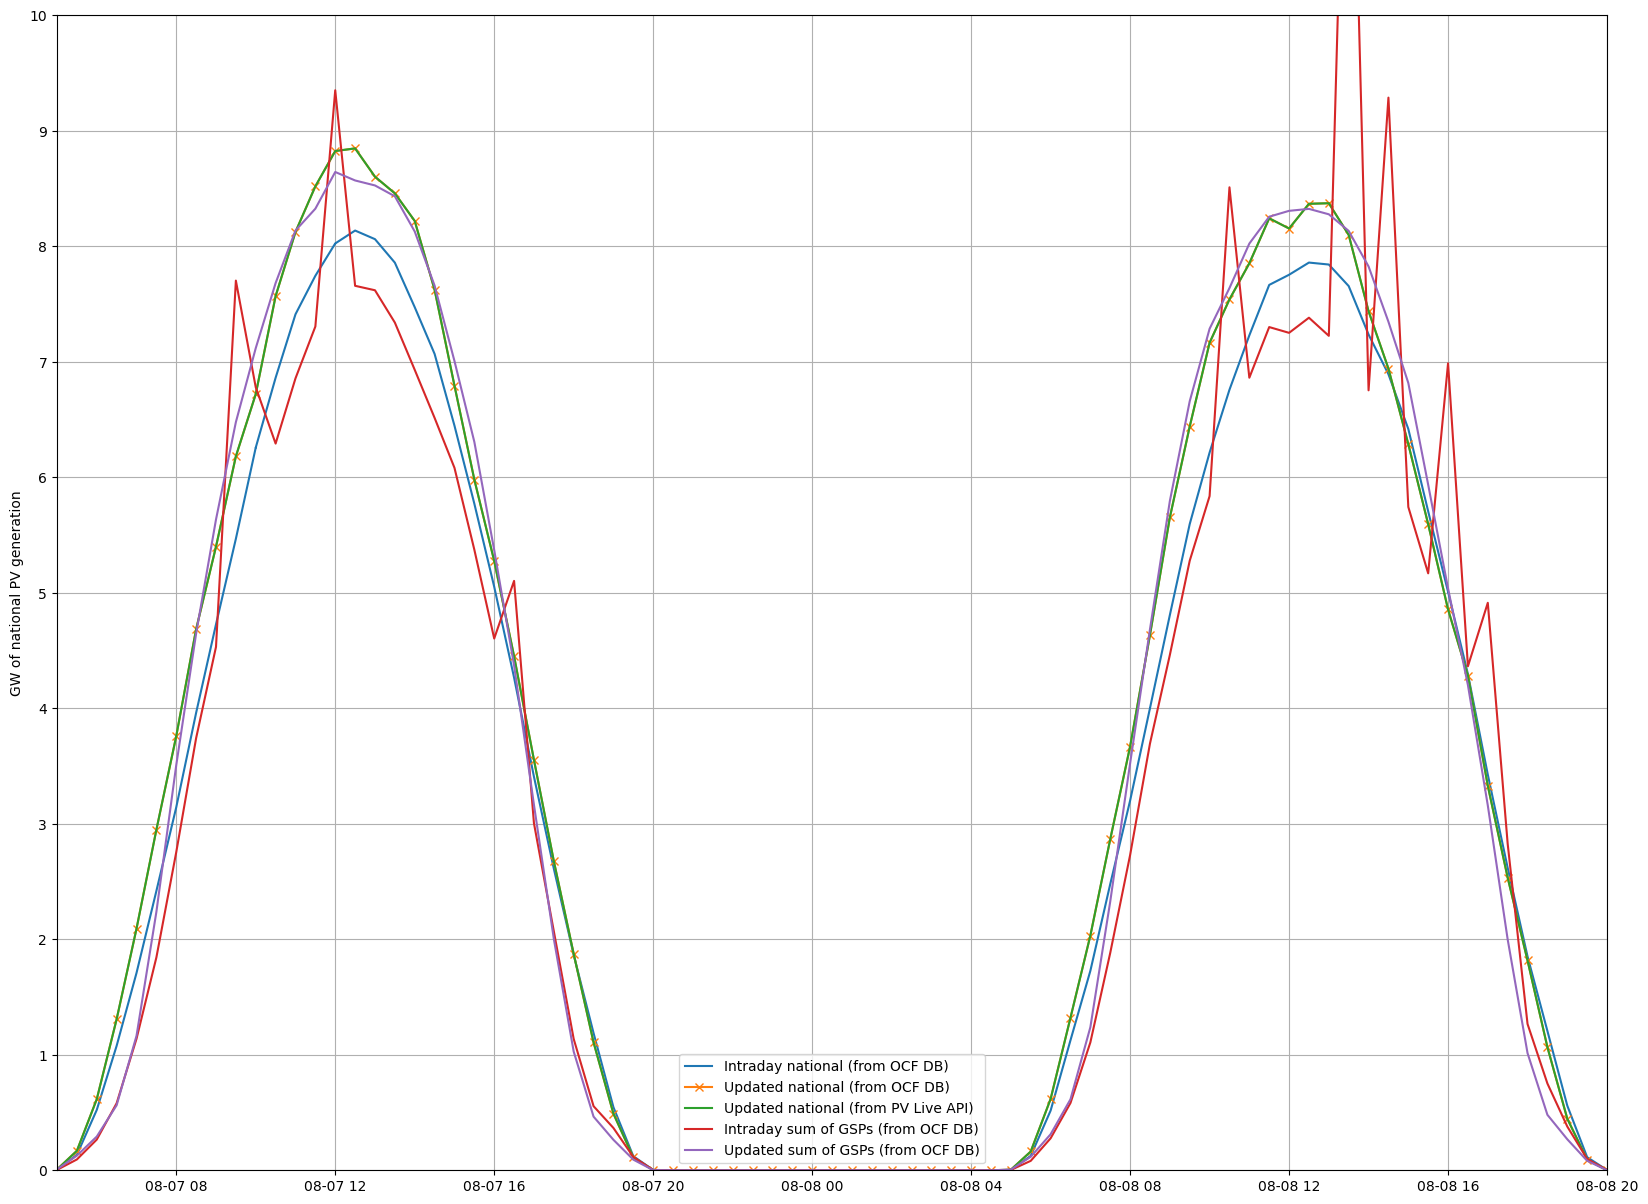

In [166]:
PLOT_SUM_OF_GSPS: Final[bool] = True

START_DATE: Final[str] = "2022-08-07 05:00"
END_DATE: Final[str] = "2022-08-08 20:00"

fig, ax = plt.subplots()

ax.plot(
    intraday_national[START_DATE:END_DATE],
    label="Intraday national (from OCF DB)",
)

ax.plot(
    updated_national[START_DATE:END_DATE],
    label="Updated national (from OCF DB)",
    marker="x",
)

# ax.plot(
#     ds.sel(gsp_id=0, datetime_gmt=slice(START_DATE, END_DATE))["generation_mw"].to_series() / 1E3,
#     label="Updated national (from training dataset)",
# )

ax.plot(
    national_gw_from_pv_live_api[START_DATE:END_DATE],
    label="Updated national (from PV Live API)",
)

if PLOT_SUM_OF_GSPS:
    ax.plot(
        intraday_sum_of_gsps[START_DATE:END_DATE],
        label="Intraday sum of GSPs (from OCF DB)",
    )

    ax.plot(
        updated_sum_of_gsps[START_DATE:END_DATE],
        label="Updated sum of GSPs (from OCF DB)",
    )
    
    # ax.plot(
    #     ds.sel(gsp_id=slice(1, None), datetime_gmt=slice(START_DATE, END_DATE))["generation_mw"].sum("gsp_id").to_series() / 1E3,
    #     label="Updated sum of GSPs (from training dataset)",
    # )

ax.legend()
ax.grid()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel("GW of national PV generation")
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.set_xlim(
    mdates.datestr2num(START_DATE),
    mdates.datestr2num(END_DATE),  
)
ax.set_ylim([0, 10])

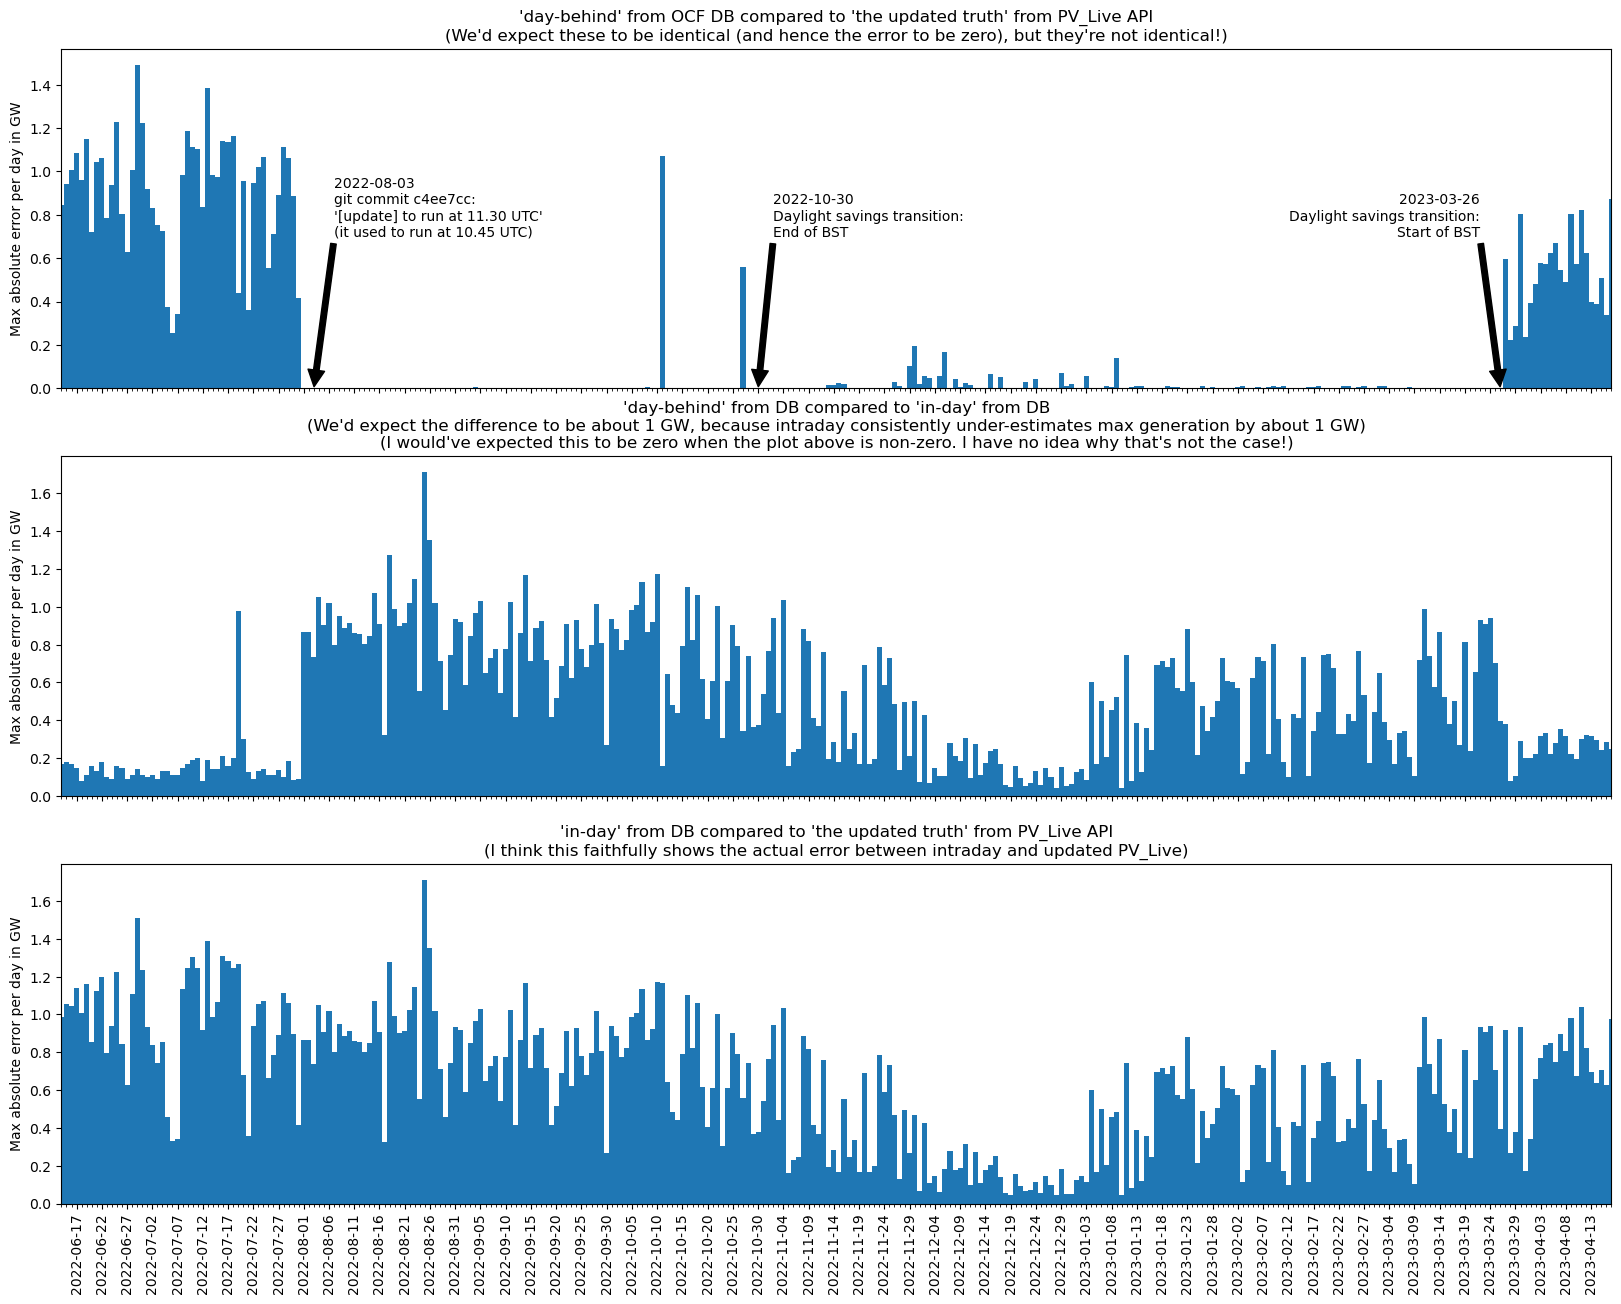

In [158]:
SIMPLE_PLOT: Final[bool] = False
BAR_KWARGS: Final[dict] = dict(
    width=1,
    linewidth=0,
)

fig, axes = plt.subplots(
    nrows=1 if SIMPLE_PLOT else 3,
    sharex=True,
)

ax = axes if SIMPLE_PLOT else axes[0]
ax.set_title("'day-behind' from OCF DB compared to 'the updated truth' from PV_Live API\n(We'd expect these to be identical (and hence the error to be zero), but they're not identical!)")
errors_updated = (updated_national - national_gw_from_pv_live_api).dropna().abs().resample("D").max()
ax.bar(
    x=errors_updated.index,
    height=errors_updated,
    **BAR_KWARGS,

)
ax.set_ylabel("Max absolute error per day in GW")

# Annotation about git commit:
ax.annotate(
    "2022-08-03\ngit commit c4ee7cc:\n'[update] to run at 11.30 UTC'\n(it used to run at 10.45 UTC)",
    xy=(pd.Timestamp("2022-08-03"), 0.0),
    xytext=(pd.Timestamp("2022-08-07"), 0.7),
    arrowprops=dict(facecolor='black', shrink=0.01),    
)

# Annotation about BST ending:
ax.annotate(
    "2022-10-30\nDaylight savings transition:\nEnd of BST",
    xy=(pd.Timestamp("2022-10-30"), 0.0),
    xytext=(pd.Timestamp("2022-11-02"), 0.7),
    arrowprops=dict(facecolor='black', shrink=0.01),    
)

# Annotation about BST starting:
ax.annotate(
    "2023-03-26\nDaylight savings transition:\nStart of BST",
    xy=(pd.Timestamp("2023-03-26"), 0),
    xytext=(pd.Timestamp("2023-03-22"), 0.7),
    arrowprops=dict(facecolor='black', shrink=0.01),
    horizontalalignment='right',
)

if not SIMPLE_PLOT:
    ax = axes[1]
    ax.set_title("'day-behind' from DB compared to 'in-day' from DB\n(We'd expect the difference to be about 1 GW, because intraday consistently under-estimates max generation by about 1 GW)\n(I would've expected this to be zero when the plot above is non-zero. I have no idea why that's not the case!)")
    errors = (updated_national - intraday_national).dropna().abs().resample("D").max()
    ax.bar(
        x=errors.index,
        height=errors,
        **BAR_KWARGS,
    )
    ax.set_ylabel("Max absolute error per day in GW")

    ax = axes[2]
    ax.set_title("'in-day' from DB compared to 'the updated truth' from PV_Live API\n(I think this faithfully shows the actual error between intraday and updated PV_Live)")
    errors = (intraday_national - national_gw_from_pv_live_api).dropna().abs().resample("D").max()
    ax.bar(
        x=errors.index,
        height=errors,
    **BAR_KWARGS,
    )
    ax.set_ylabel("Max absolute error per day in GW")

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlim([
    errors_updated.index[0],
    errors_updated.index[-10],
]);